In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

2025-02-09 12:54:06.359095: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 12:54:06.373311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739105646.393614   19264 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739105646.399670   19264 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 12:54:06.414958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
TRAIN_PATH = "DATASET/TRAIN"
TEST_PATH = "DATASET/TEST"

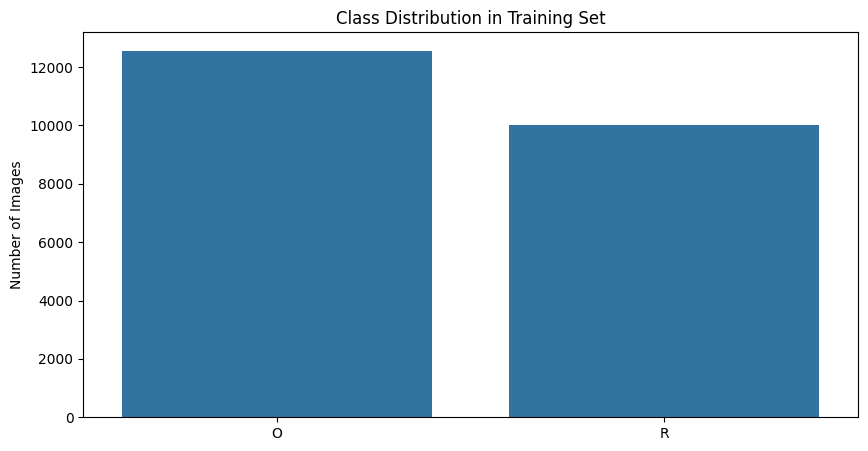

In [8]:
class_counts = {}
for class_name in os.listdir(TRAIN_PATH):
    class_counts[class_name] = len(os.listdir(os.path.join(TRAIN_PATH, class_name)))
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Images')
plt.show()

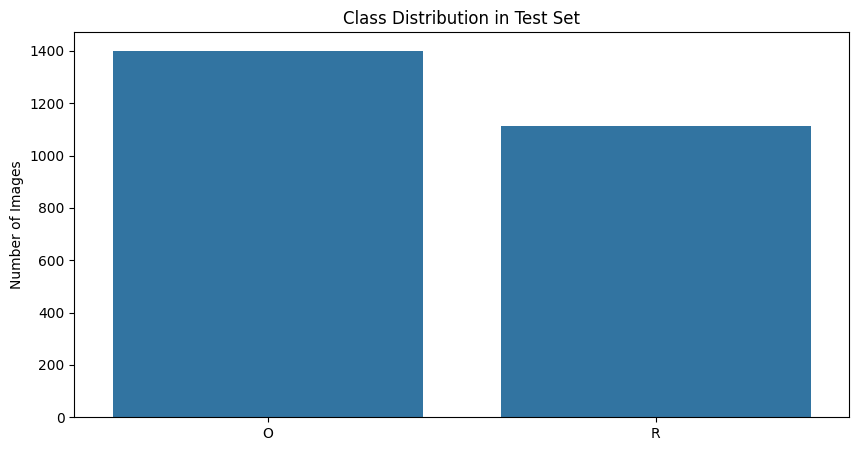

In [9]:
class_counts = {}
for class_name in os.listdir(TEST_PATH):
    class_counts[class_name] = len(os.listdir(os.path.join(TEST_PATH, class_name)))
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Test Set')
plt.ylabel('Number of Images')
plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [16]:
def create_model():
    with tf.device('/GPU:0'):
        model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

I0000 00:00:1739086653.106310    2158 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1739086659.123100    3600 service.cc:148] XLA service 0x7f7d44007440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739086659.123435    3600 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-02-09 07:37:39.185119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739086659.437997    3600 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/565 ━━━━━━━━━━━━━━━━━━━━ 51:57 6s/step - accuracy: 0.4688 - loss: 1.2899

I0000 00:00:1739086662.051872    3600 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


565/565 ━━━━━━━━━━━━━━━━━━━━ 163s 278ms/step - accuracy: 0.7180 - loss: 4.8962 - val_accuracy: 0.6625 - val_loss: 1.4672
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 143s 252ms/step - accuracy: 0.7891 - loss: 0.5428 - val_accuracy: 0.6219 - val_loss: 0.7136
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 143s 253ms/step - accuracy: 0.8038 - loss: 0.4905 - val_accuracy: 0.8293 - val_loss: 0.3721
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 142s 252ms/step - accuracy: 0.7927 - loss: 0.5427 - val_accuracy: 0.7569 - val_loss: 0.6277
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 142s 251ms/step - accuracy: 0.8076 - loss: 0.4350 - val_accuracy: 0.6598 - val_loss: 0.7203
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 141s 250ms/step - accuracy: 0.8172 - loss: 0.4465 - val_accuracy: 0.6483 - val_loss: 0.5937
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 141s 250ms/step - accuracy: 0.8088 - loss: 0.4517 - val_accuracy: 0.6350 - val_loss: 1.3813
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 142s 251ms/step - accuracy: 0.8129 - loss: 0.42

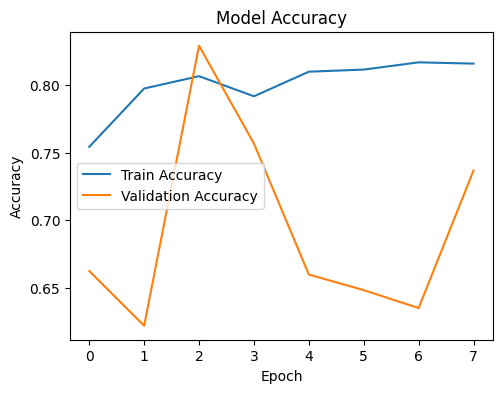

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

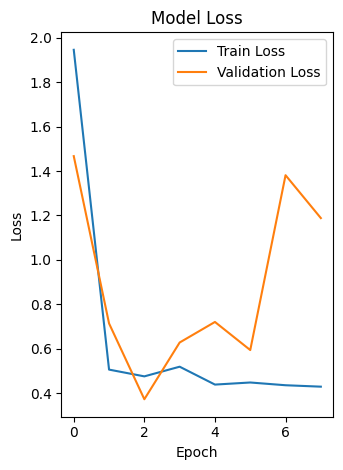

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Best Model Test Accuracy: {test_acc:.2%}")

2025-02-09 12:54:27.301487: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1739105668.667180   21756 service.cc:148] XLA service 0x7fd18c00afe0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739105668.667234   21756 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-09 12:54:28.683200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739105668.812448   21756 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of

79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.9184 - loss: 0.2366
Best Model Test Accuracy: 85.08%


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 358ms/step
Classification Report:
              precision    recall  f1-score   support

           O       0.83      0.93      0.87      1401
           R       0.89      0.76      0.82      1112

    accuracy                           0.85      2513
   macro avg       0.86      0.84      0.85      2513
weighted avg       0.86      0.85      0.85      2513



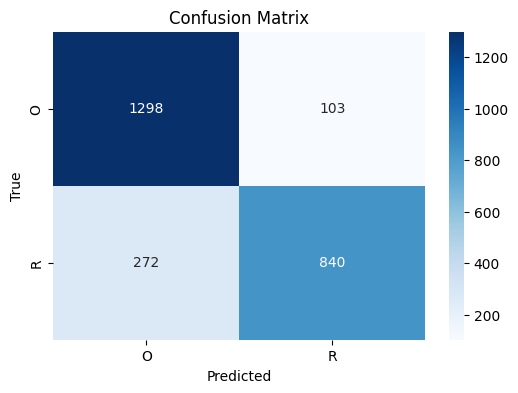

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


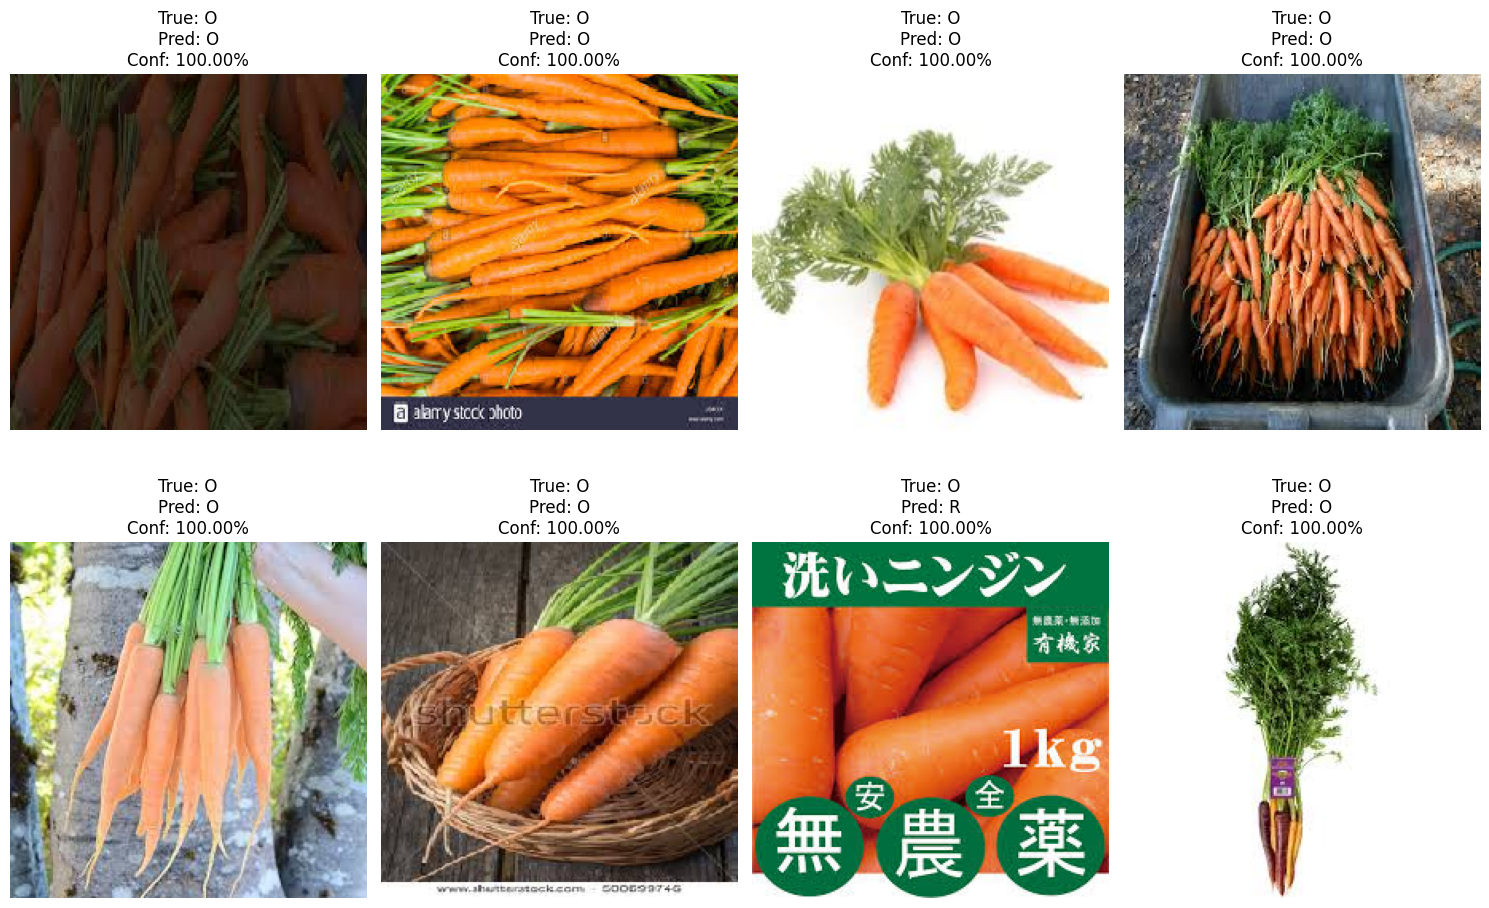

In [12]:
import matplotlib.pyplot as plt
test_images, test_labels = next(test_generator)
predictions = best_model.predict(test_images)
predictions = (predictions > 0.5).astype(int)
plt.figure(figsize=(15, 10))
for i in range(8):  # Display 8 samples
    plt.subplot(2, 4, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[int(test_labels[i])]
    pred_label = class_names[predictions[i][0]]
    confidence = predictions[i][0] if predictions[i][0] > 0.5 else 1 - predictions[i][0]
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}")
    plt.axis('off')

plt.tight_layout()
plt.show()